# Modelling

## Introduction

In this notebook, I will explore the models and techniques in detail, and try to evaluate thier performances.  
I will also try to explain what each model is trying to do, and is it working for this case.  
The contents covered are:
1. [Baseline](#Baseline)
2. [Naive Bayes](#Naive-Bayes)
3. [Ensemble Methods](#Ensemble-Methods)
4. XGB
5. Word Embedding?
6. spaCy?

In [1]:
import joblib
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import re

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction import text 
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin

from scipy.stats import shapiro

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
df = pd.read_csv('../data/combined_df.csv')

In [3]:
df.head()

,id,title,post_content,user,label,title_word_count,title_len,post_word_count,post_len,emoji_num,emoji_post
0,119r7rg,THROWDOWN THURSDAY: LEAKS CONFIRM LINK IS IN T...,"WELCOME TO THROWDOWN THURSDAY, TURN YOUR CAPS ...",1338h4x,1,11,65,114,674,0,0
1,11c6ol7,"smile sunday - happy 30th anniversary, star fox!",turn your caps lock off and rave about whateve...,tale-wind,1,8,48,231,1515,0,0
2,11cai3l,Never played a Pokémon game- where do I start?,I’ve been a gamer since early Gameboy days but...,Focusboy50,1,9,46,60,320,0,0
3,11bipdi,Universal Brazil posted a video of a Mario mov...,NaN,Nas160,1,21,114,0,0,0,0
4,11bkknf,MyNintendo offering eight exclusive reversible...,NaN,blubberpuppers,1,20,139,0,0,0,0


In [4]:
df.groupby('label').count()

,id,title,post_content,user,title_word_count,title_len,post_word_count,post_len,emoji_num,emoji_post
label,,,,,,,,,,
0,1988,1988,679,1926,1988,1988,1988,1988,1988,1988
1,1916,1916,645,1799,1916,1916,1916,1916,1916,1916


## Baseline

The most base case prediction should be as follows:  
1. I look at the entire dataset and see how it is split into ninetendo and playstation.  
2. I make a guess everytime based on how many posts are from nintendo and how many posts are from play station.

I have 1988 posts from playstation.  
I have 1916 posts from ninetendo.  
I make a random number selector that simply selects 1 or 0, based on occurance of playstation and nintendo.  
(If I am to fit the entire data set to training.)

In [5]:
class BaseLineModel(object):
    '''base line model
    '''
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.rand_train()
    def rand_train(self):
        # becasue true = 1, so sum(true)/len(total) == occurance probability
        self.prob = sum(self.y)/len(self.y)
    def predict(self, X_pred,random_state = 42):
        # predict based on probability
        if random_state:
            np.random.seed(42)
        prob_0 = 1-self.prob
        prob_1 = self.prob
        pred = []
        for i in range(len(X_pred)):
            pred.append(np.random.choice([0, 1], p=[prob_0, prob_1]))
        return pred

In [6]:
def print_confusion_matrix(y_actual, y_pred):
    cf_matrix = confusion_matrix(y_actual, y_pred)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [7]:
def metrics_for_model(y_true, y_pred):
    '''find the relavent metrics from confusion metrics
    arg:
        y_true: true value for y
        y_pred: predicted value for y
    out:
        pre: precison score
        rec: recall score
        f1: f1 socre
    '''
    tn, fp, fn, tp =confusion_matrix(y_true, y_pred).ravel()
    acc = (tp+tn)/(tp+fp+tn+fn)
    pre = tp/(tp+fp)
    sp = tn/(tn+fp)
    rec = tp/(tp+fn)
    f1 = 2*(pre*rec)/(pre+rec)
    print(f"The accuracy of this inference is: {acc}")
    print(f"The precision of this inference is: {pre}")
    print(f"The specificty of this inference is: {sp}")
    print(f"The recall of this inference is: {rec}")
    print(f"The f1 score for this inference is: {f1}")
    return pre, rec, f1

In [8]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(df['title'], df['label'], test_size=0.2, random_state=42)

In [9]:
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [10]:
base_line = BaseLineModel(X_train, y_train)
y_pred_base = base_line.predict(X_test)

The accuracy of this inference is: 0.528809218950064
The precision of this inference is: 0.5406824146981627
The specificty of this inference is: 0.5418848167539267
The recall of this inference is: 0.5162907268170426
The f1 score for this inference is: 0.5282051282051281


(0.5406824146981627, 0.5162907268170426, 0.5282051282051281)

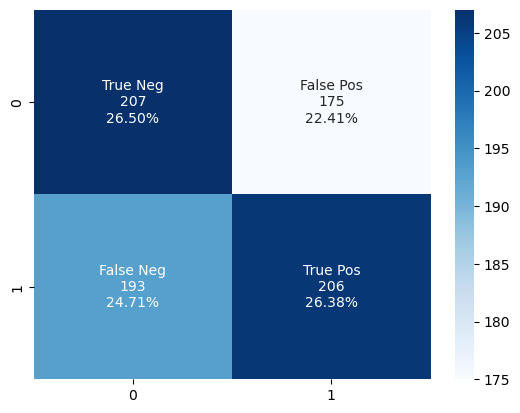

In [11]:
print_confusion_matrix(y_test, y_pred_base);
metrics_for_model(y_test, y_pred_base)

This is the my baseline model.  
It is equally bad at predicting both, and have a very even mixture for errors too!  
The main evalution metric is my coonfusion matrix.  
This is becasue confusion matrix provide the most complete information to my classification model.  
From it, my accuracy, recall, precision, specificty, f1 all can be calculated.  
What I am focusing on, is the f1 score.  
I want my model to be good for both predicting precisely (tp/tp+fp) and with good recall (tp/tp+fn).  
F1 score can also be described as the harmonic mean or weighted average of precision and recall.  
With my baseline model established, I will go on to investigate with other methods!

## Naive Bayes

I am using multinominal NB as explained in the EDA notebook.  
It is a simple classification model and commonly used in NLP tasks like that one at hand.  
I will examine some techniques and how they affect the model.  
1. Extracting words from web links.
2. Stemming
3. Lemmatization  

Then the preprocessed tokens will be sent to TF-IDF.  
After which, it will be fitted using NB.
I will then examine the model and decide which variant of the model to use, should I want a NB model for production.

In [12]:
# Import my stop words
with open('../data/stopwords.pkl', 'rb') as f:
    my_stop_words = pickle.load(f)

In [13]:
class StemLemmatizeTransformer(BaseEstimator, TransformerMixin):
    '''Class that 
    1. extract words from url
    2. stem words
    3. lemmatize words
    '''
    def __init__(self):
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        stemmed_lemmatized_text = []
        replace_list = ['apps.', 'http://', 'https://', 'www.', '.net', '.com', '/', '.', '-']
        for i, text in enumerate(X):
            for part in replace_list:
                text = text.replace(part, ' ')
            # X[i] = text
            stemmed_words = [self.stemmer.stem(word) for word in text.split()]
            stemmed_lemmatized_text.append(' '.join([self.lemmatizer.lemmatize(word) for word in stemmed_words]))
        return stemmed_lemmatized_text

In [14]:
final_nb_pipeline = Pipeline([
    ('stem_lemmatize', StemLemmatizeTransformer()),
    ('tfidf', TfidfVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)),
    ('clf', MultinomialNB()),
])


In [15]:
final_nb_model = final_nb_pipeline.fit(X_train, y_train)

In [16]:
y_pred_nb = final_nb_model.predict(X_test)

The accuracy of this inference is: 0.8796414852752881
The precision of this inference is: 0.9066666666666666
The specificty of this inference is: 0.9083769633507853
The recall of this inference is: 0.8521303258145363
The f1 score for this inference is: 0.8785529715762274


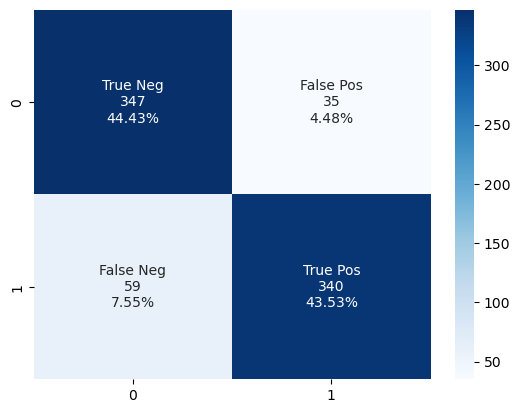

In [17]:
print_confusion_matrix(y_test, y_pred_nb)
metrics_for_model(y_test, y_pred_nb);

In [18]:
df_comb = pd.concat([X_test, y_test, pd.DataFrame(y_pred_nb, columns=['y_pred_nb'])], axis=1)
df_comb.loc[df_comb['label'] != df_comb['y_pred_nb']]

,title,label,y_pred_nb
4,It’s weird how Sakurai is the only “employee” ...,1,0
34,PSA: If you're having issues with your Switch ...,1,0
41,WARNING DON'T Upload photos on nintendo live chat,1,0
53,Every Issue of Nintendo Power uploaded to arch...,1,0
60,Theogony of Hyrule: The Tale of the Goddess Hy...,1,0
...,...,...,...
746,Next EU Splatfest: Should the toilet roll hang...,1,0
747,Tis the season on the Starfall Islands. You ca...,1,0
749,"As a kid, Nintendo helped me earn my Bear Badge.",1,0
766,Galar Region is based off the UK. Victorian-es...,1,0


The accuracy of this inference is: 0.8860435339308579
The precision of this inference is: 0.9078947368421053
The specificty of this inference is: 0.9083769633507853
The recall of this inference is: 0.8646616541353384
The f1 score for this inference is: 0.8857509627727858


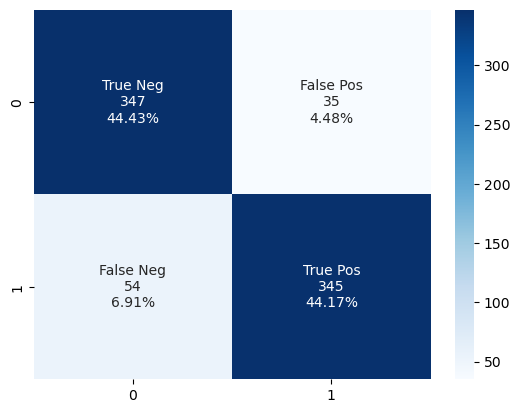

In [19]:
# compare it with my prelim model without the removal of key words
prelim_nb_model = joblib.load('../model/prelim_model.joblib')
y_pred_prelim_nb = prelim_nb_model.predict(X_test)
print_confusion_matrix(y_test, y_pred_prelim_nb)
metrics_for_model(y_test, y_pred_prelim_nb);

In [20]:
df_comb = pd.concat([df_comb, pd.DataFrame(y_pred_prelim_nb, columns=['y_prelim_nb'])], axis=1)
df_comb.loc[df_comb['label'] != df_comb['y_prelim_nb']]

,title,label,y_pred_nb,y_prelim_nb
4,It’s weird how Sakurai is the only “employee” ...,1,0,0
7,Spider Man trailer with 90s theme,0,0,1
52,"If Nintendo could give you one ""gift,"" as in a...",1,1,0
53,Every Issue of Nintendo Power uploaded to arch...,1,0,0
54,PSA for those looking at the legend of dragoon...,0,0,1
...,...,...,...,...
747,Tis the season on the Starfall Islands. You ca...,1,0,0
748,Nintendo's next console will lean towards stre...,1,1,0
749,"As a kid, Nintendo helped me earn my Bear Badge.",1,0,0
762,You can't convert replays to video unless you ...,1,1,0


Unfortunately, the performance is very slightly worse than my preliminary model with key give away words removed.    
Comparing my model in EDA notebook with removal of the stop words, this current 'final' model have a slightly lower `true positive` count, and a slightly `higher flase negative`.  

---
What this means is that my combination of stemming and lemmatization and N-grams makes no major improvement to the model.  
If fact, they might have tightened the 'bound' the model used to determine a post title as `true positive`.  
It is more difficult to be passsed as a title from `ninetendo` post.   
This is very likely due to the inclusion of stemming and lemmatization.  
Stemming is a more aggressive technique where words are truncated to their root form, whereas lemmatization is a more precise technique that considers the context of the word and reduces it to its base form.
Combining both techniques, I am reducing the size of the vocabulary, and hoping it will increase the accuracy of the model.   
However, in this case it did not achieve what I hope it can achieve.  
This could be due to stemming removing too much of a word.  
Let me do an experiment to confirm a few things:
1. it is becasue of stemming and lemmatization.
2. it is mainly due to stemming. 
3. TFIDF using N-grams does not impact this use case much.

In [21]:
# Build a pipeline without the stemming and lemmatization.
final_nb_pipeline_2 = Pipeline([
    # ('stem_lemmatize', StemLemmatizeTransformer()),
    ('tfidf', TfidfVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)),
    ('clf', MultinomialNB()),
])

The accuracy of this inference is: 0.8886043533930857
The precision of this inference is: 0.9216216216216216
The specificty of this inference is: 0.9240837696335078
The recall of this inference is: 0.8546365914786967
The f1 score for this inference is: 0.8868660598179453


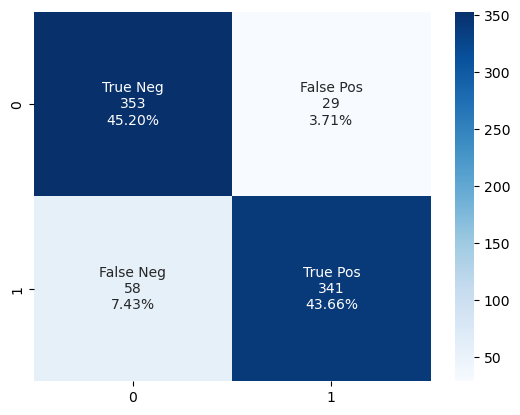

In [22]:
final_nb_pipeline_2.fit(X_train, y_train)
y_pred_nb_2 = final_nb_pipeline_2.predict(X_test)
print_confusion_matrix(y_test, y_pred_nb_2)
metrics_for_model(y_test, y_pred_nb_2);

Yes! As I have hypothesised, the stemming and lemmatization actually decreased the performance of the model.  
How the above model is different from my EDA model is that, this model uses n-grams.  
N-grams takes N words/ tokens in a document and use them as feature.   
N-grams during the tokenisation process helps to retain some information on the context of the words.  
Indeed, with n-grams the `true nrgatives` have a better performance as the `false positive` decreases.   
However, the performance improvement is not too much. 
This also serve as a proof to my third hypothesis, inclusion of n-grams, or at least up to trigram, doesn't drastically the performance of the model in this case.   
Also, if I decrease the minimum document frequency `min_df`, it will result in a better performance in this case.  
However, since I still want to keep my model more generalised, I feel that a small drop in performance is reasonable.  
Therefore, I am still keeping `min_df = 5`.

In [23]:
df_comb = pd.concat([df_comb, pd.DataFrame(y_pred_nb_2, columns=['y_pred_nb_2'])], axis=1)
df_comb.loc[df_comb['label'] != df_comb['y_pred_nb_2']]

,title,label,y_pred_nb,y_prelim_nb,y_pred_nb_2
4,It’s weird how Sakurai is the only “employee” ...,1,0,0,0
53,Every Issue of Nintendo Power uploaded to arch...,1,0,0,0
69,You can buy a brand new sealed copy of LarryBo...,1,0,0,0
77,How simple texture compression can start a 20-...,1,0,0,0
79,Been online friends since Destiny launch in 20...,0,1,1,1
...,...,...,...,...,...
747,Tis the season on the Starfall Islands. You ca...,1,0,0,0
748,Nintendo's next console will lean towards stre...,1,1,0,0
749,"As a kid, Nintendo helped me earn my Bear Badge.",1,0,0,0
762,You can't convert replays to video unless you ...,1,1,0,0


Just by looking at the results of what went wrong, some very consistent mistakes can be found here.  
Like theese lines:   
`It’s weird how Sakurai is the only “employee” ...`,   
`Adding a search by publisher/maker`,   
`Do you think the Xenoblade Chronicles games wo...`
These are the sentences that may not be covered by the traning set.  
I can try to keep updating my dataset.  


---
Now, time to check my 2nd hypothesis.   
Check is the problem due to stemming or lemmatization.  
That process is a bit mundane (edititng the 3 parts that forms my StemLemmatizeTransformer class) and I shall skip the process here.   
Let me just get stright to the results.  
I have tried 4 things in total for this part.  
1. No breaking down weblink.
2. No stemming.
3. No lemmatization.
4. No stemming and lemmatization.  
Here are the results.   

### No breaking web links
<img src='../img/remove_link_stripe.png' width="400" height="400"></img>
### No stemming
<img src='../img/no_stem.png' width="400" height="400"></img>
### No lemmatization
<img src='../img/no_lemma.png' width="400" height="400"></img>
### No stemming & lemmatization
<img src='../img/no_stem_n_lemma.png' width="400" height="400"></img>

Now, it should be obvious that both stemming and lemmatizition helpped to generalise the model...  
At the cost of a few `True Negatives`.  
Breaking the weblink or not, doesn't really matter.  
This could be because I dont have weblink in my test data?  
Anyways, via the experiments I have done, it doesn't really matter.  
Therefore, the final Multinominal Naive Bayes model/ pipeline I will use is my `final_nb_pipeline_2`.  
By having minmum document frequency of 5, and using n-grams from 1 to 3, I am able to achieve a relatively light weight, yet accurate model with good performance.  

---
Since my goal is to accurately predict the origin of my post title, the selected pipeline, offering a f1-score of 0.8868, is suitable for this job.  

## Ensemble Methods

Ensemble methods are ML techniques that helps to improve accuracy by combining multiple models, instead of just using a single model.  
The three most common methods under ensemble are:  
1. Bagging (Bootstrap aggregating)
2. Boosting (Converting multiple weak learners into a single strong learning model)
3. Stacking (Combining different models to best answer the question)  

Bagging is random sampling with replacement from the available training data and make an estimator with each bootstrapped dataset, same model trained on the same dataset.  
Boosting is making a series of weak learners that learns to avoid the mistake made by the previous one, or sequence of models that correct the predictions of prior models.
Stacking is having a model that combines 2 or more models that each have thier individual strengths, different level 0 models trained on same dataset combined by a level 1 model.   

I will explore:
1. [RF](#RF)
2. [XGB](#XGB)

Stacking will not be explored here.

### RF

Random Forest is a famous bagging method!  
In this notebook, I will try to use the Random Forest Classifier.  

In [37]:
RF_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)),
    # ('cvec', CountVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)),
    ('RF', RandomForestClassifier(
        n_estimators=500, 
        max_depth=250, 
        min_samples_split=2, 
        min_samples_leaf=1,
    )),
])

In [38]:
RF_pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 3),
                                 stop_words={'a', 'about', 'above', 'across',
                                             'after', 'afterwards', 'again',
                                             'against', 'ain', 'all', 'almost',
                                             'alone', 'along', 'already',
                                             'also', 'although', 'always', 'am',
                                             'among', 'amongst', 'amoungst',
                                             'amount', 'an', 'and', 'another',
                                             'any', 'anyhow', 'anyone',
                                             'anything', 'anyway', ...})),
                ('RF',
                 RandomForestClassifier(max_depth=250, n_estimators=500))])

The accuracy of this inference is: 0.882202304737516
The precision of this inference is: 0.9137466307277629
The specificty of this inference is: 0.9162303664921466
The recall of this inference is: 0.849624060150376
The f1 score for this inference is: 0.8805194805194806


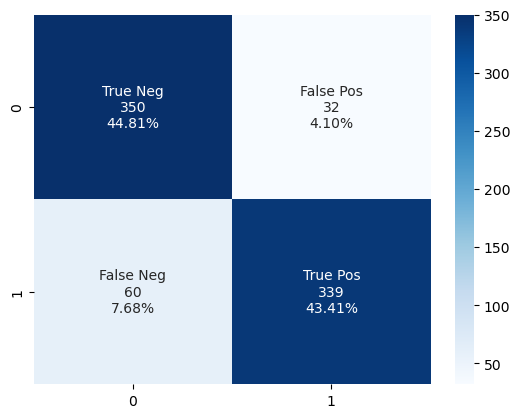

In [39]:
y_pred_RF = RF_pipeline.predict(X_test)
print_confusion_matrix(y_test, y_pred_RF)
metrics_for_model(y_test, y_pred_RF);

In [27]:
df_comb = pd.concat([df_comb, pd.DataFrame(y_pred_RF, columns=['y_pred_RF'])], axis=1)
df_comb.loc[df_comb['label'] != df_comb['y_pred_RF']]

,title,label,y_pred_nb,y_prelim_nb,y_pred_nb_2,y_pred_RF
7,Spider Man trailer with 90s theme,0,0,1,0,1
41,WARNING DON'T Upload photos on nintendo live chat,1,0,1,1,0
54,PSA for those looking at the legend of dragoon...,0,0,1,0,1
77,How simple texture compression can start a 20-...,1,0,0,0,0
79,Been online friends since Destiny launch in 20...,0,1,1,1,1
...,...,...,...,...,...,...
747,Tis the season on the Starfall Islands. You ca...,1,0,0,0,0
748,Nintendo's next console will lean towards stre...,1,1,0,0,0
749,"As a kid, Nintendo helped me earn my Bear Badge.",1,0,0,0,0
766,Galar Region is based off the UK. Victorian-es...,1,0,1,1,0


Machine learning is not magic.   
It is math and statistics, based on data.  
Some problem that can't be solved using simpler models, can't be solved by RF as well.  
For example:   
line 77: `How simple texture compression can start a 20-...`  
line 79: `Been online friends since Destiny launch in 20...`  
line 747: `Tis the season on the Starfall Islands. You ca...`  
line 769: `Japan Is More Excited About Nintendo Labo Than...`  
Some of thses problems can be solved by allowing `nintendo` and `playstation` in the document.  
Also, lowering the minimum document frequency always helps.  

In [40]:
RF_params = {'n_estimators':[100, 200, 300, 400, 500], 
             'max_depth':[100, 150, 200, 250], 
             'min_samples_split':[6, 4 ,2], 
             'min_samples_leaf':[3,2,1],
            }

In [44]:
grid_search = GridSearchCV(RandomForestClassifier(),
                           param_grid=RF_params,
                           cv=5,
                           )

rf_grid_search_CV = Pipeline(
    steps=[('tfidf', TfidfVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)), 
           ("RF Grid Search", grid_search)]
) 

In this case, the X_train is further split into 5 sets and used to train and fit the model.  
The line below examines a total of 900 fits.  
It can take a long time.

In [45]:
rf_grid_search_CV.fit(X_train, y_train)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(min_df=5, ngram_range=(1, 3),
                                 stop_words={'a', 'about', 'above', 'across',
                                             'after', 'afterwards', 'again',
                                             'against', 'ain', 'all', 'almost',
                                             'alone', 'along', 'already',
                                             'also', 'although', 'always', 'am',
                                             'among', 'amongst', 'amoungst',
                                             'amount', 'an', 'and', 'another',
                                             'any', 'anyhow', 'anyone',
                                             'anything', 'anyway', ...})),
                ('RF Grid Search',
                 GridSearchCV(cv=5, estimator=RandomForestClassifier(),
                              param_grid={'max_depth': [100, 150, 200, 250],
                                          'min_samples_leaf': [3, 2, 1],
                                          'min_samples_split': [6, 4, 2],
                                          'n_estimators': [100, 200, 300, 400,
                                                           500]}))])

In [47]:
print("Best parameters: ", rf_grid_search_CV[1].best_score_)

Best parameters:  0.8888882051282051


In [48]:
print("Best parameters: ", rf_grid_search_CV[1].best_params_)

Best parameters:  {'max_depth': 250, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}


In [49]:
# Train a model using the parameters above.
RF_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)),
    # ('cvec', CountVectorizer(min_df=5, ngram_range=(1,3), stop_words=my_stop_words)),
    ('RF', RandomForestClassifier(
        n_estimators=300, 
        max_depth=250, 
        min_samples_split=4, 
        min_samples_leaf=1,
    )),
])

The accuracy of this inference is: 0.8834827144686299
The precision of this inference is: 0.9184782608695652
The specificty of this inference is: 0.9214659685863874
The recall of this inference is: 0.8471177944862155
The f1 score for this inference is: 0.8813559322033897


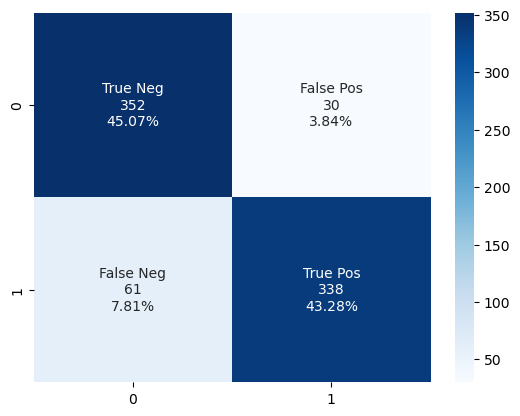

In [50]:
RF_pipeline.fit(X_train, y_train)
y_final_RF_pred = RF_pipeline.predict(X_test)
print_confusion_matrix(y_test, y_final_RF_pred)
metrics_for_model(y_test, y_final_RF_pred);

### XGB

Extreme Gradient Boost, a state of the art boosting method!

In [6]:

class StemLemmaTfidfLDA(BaseEstimator, TransformerMixin):
    def __init__(self, stop_words='english', max_features=5000, n_components=10, max_df=0.95, min_df=2):
        self.stemmer = SnowballStemmer('english')
        self.lemmatizer = WordNetLemmatizer()
        self.tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, max_features=max_features)
        self.lda_model = LatentDirichletAllocation(n_components=n_components, max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
        self.max_df = max_df
        self.min_df = min_df
    
    def stem_and_lemmatize(self, document):
        return [self.stemmer.stem(self.lemmatizer.lemmatize(token)) for token in document.split()]

    def fit(self, X, y=None):
        X_stemmed_lemmatized = [' '.join(self.stem_and_lemmatize(document)) for document in X]
        X_tfidf = self.tfidf_vectorizer.fit_transform(X_stemmed_lemmatized)
        self.lda_model.fit(X_tfidf)
        return self

    def transform(self, X):
        X_stemmed_lemmatized = [' '.join(self.stem_and_lemmatize(document)) for document in X]
        X_tfidf = self.tfidf_vectorizer.transform(X_stemmed_lemmatized)
        X_lda = self.lda_model.transform(X_tfidf)
        return X_lda


In [23]:
def metrics_for_model(y_true, y_pred):
    '''find the relavent metrics from confusion metrics
    arg:
        y_true: true value for y
        y_pred: predicted value for y
    out:
        pre: precison score
        rec: recall score
        f1: f1 socre
    '''
    tn, fp, fn, tp =confusion_matrix(y_true, y_pred).ravel()
    pre = tp/(tp+fp)
    rec = tp/(tp+fn)
    f1 = 2*(pre*rec)/(pre+rec)
    print(f"The recall of this inference is: {rec}")
    print(f"The precision of this inference is: {pre}")
    print(f"The f1 score for this inference is: {f1}")
    return pre, rec, f1

In [24]:
metrics_for_model(df['label'], df['pred']);

The recall of this inference is: 0.9525052192066806
The precision of this inference is: 0.9769807280513919
The f1 score for this inference is: 0.9645877378435519


In [ ]:
# dnn based idea generator that make weak links.
# then use GAN to determine if the idea is feasible.

In [ ]:
import numpy as np
import spacy
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from gensim.models import KeyedVectors


class StemLemmatizeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    
    def stem(self, word):
        stemmer = SnowballStemmer("english")
        return stemmer.stem(word)

    def lemmatize(self, doc):
        doc = self.nlp(doc)
        return [token.lemma_ for token in doc]

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.apply(lambda x: " ".join([self.stem(w) for w in x.split()]))
        X = X.apply(lambda x: " ".join(self.lemmatize(x)))
        return X


class WordEmbeddingsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, embeddings_file):
        self.embeddings_file = embeddings_file

    def fit(self, X, y=None):
        self.word_vectors = KeyedVectors.load_word2vec_format(self.embeddings_file, binary=False)
        return self

    def transform(self, X):
        X_embedded = []
        for sentence in X:
            embedded_sentence = []
            for word in sentence.split():
                if word in self.word_vectors:
                    embedded_sentence.append(self.word_vectors[word])
            if len(embedded_sentence) > 0:
                X_embedded.append(np.mean(embedded_sentence, axis=0))
            else:
                X_embedded.append(np.zeros(100))
        return np.array(X_embedded)

pipeline = Pipeline([
    ('stem_lemmatize', StemLemmatizeTransformer()),
    ('tfidf', TfidfVectorizer()),
    ('embeddings', WordEmbeddingsTransformer(embeddings_file='/path/to/glove.6B.100d.txt'))
])
